# PyMC and Universal Samplers

## Part A: `import pymc`

In [2]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [3]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.10.4


In [4]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

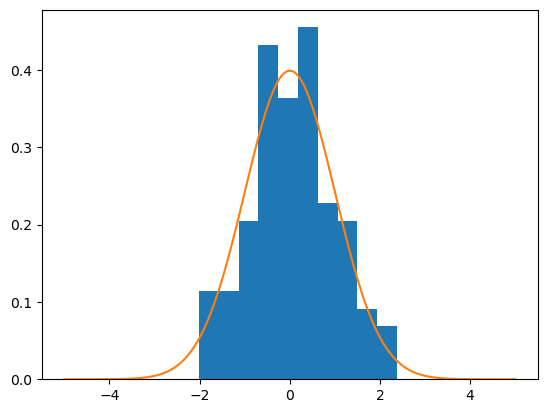

In [5]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [6]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma: # conjugate is when the posterior has the same distribution family as the prior

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data - prior "adds one data point"
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau  
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

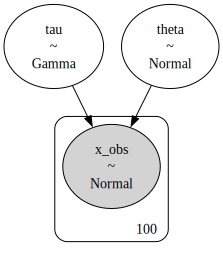

In [7]:
pymc.model_to_graphviz(conjugate_normal_gamma)

In [8]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [9]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [10]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    tau      (chain, draw) float64 160kB 1.216 1.033 1.04 ... 1.148 1.195 1.029
    theta    (chain, draw) float64 160kB 0.1998 -0.01698 ... 0.0149 0.127
Attributes:
    created_at:                 2025-02-11T01:06:16.810163+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              5.736432790756226
    tuning_steps:               100

In [11]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[ 0.19984334, -0.01698158,  0.03800759, ...,  0.07491754,
         0.11009564,  0.05344253],
       [ 0.05631743,  0.08060616,  0.04393091, ...,  0.15457252,
         0.01490189,  0.1269642 ]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [12]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.21647089, 1.03257064, 1.04001648, ..., 1.11328552, 1.20314415,
        1.35755761],
       [1.08512613, 1.15704074, 1.09615186, ..., 1.1483444 , 1.19542234,
        1.02904668]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

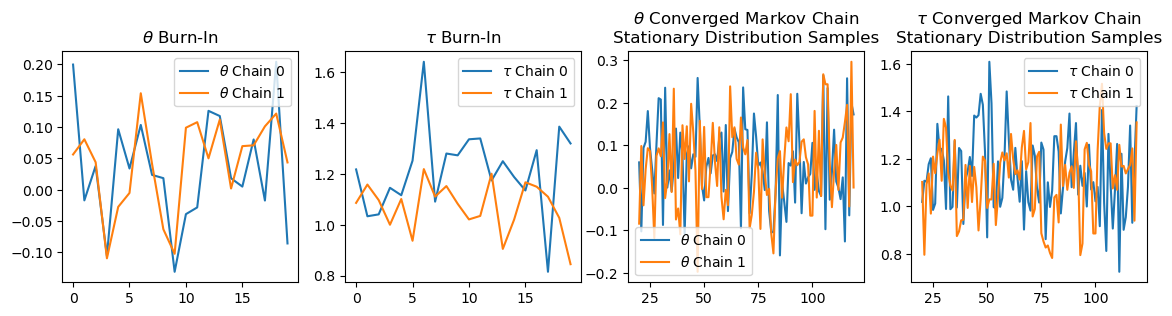

In [13]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

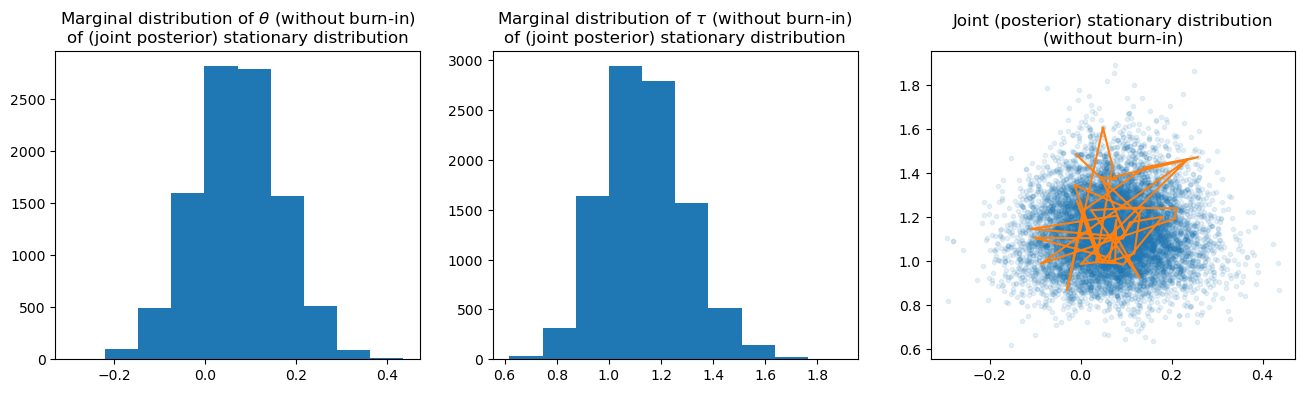

In [14]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [15]:
import arviz as az

In [16]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

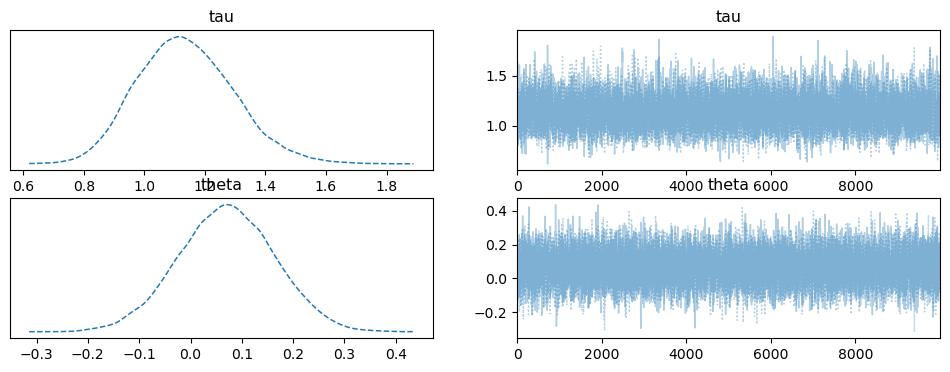

In [17]:
az.plot_trace(idata, combined=True);

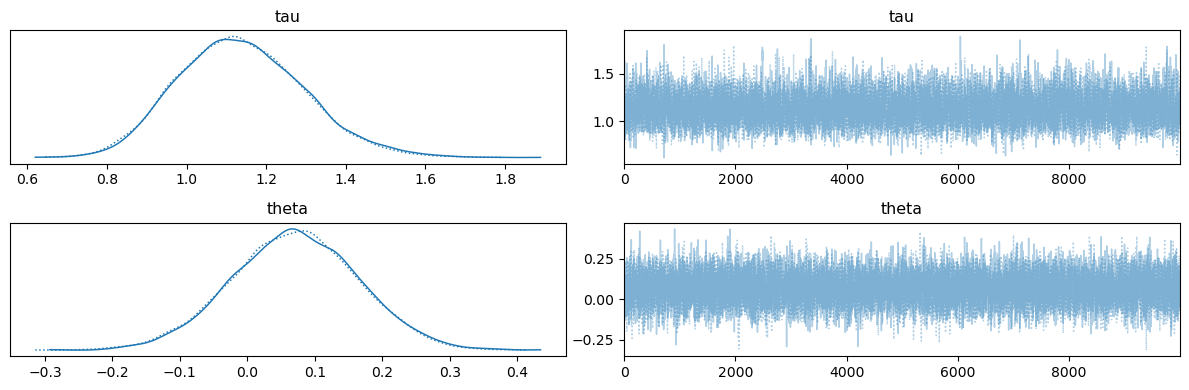

In [18]:
az.plot_trace(idata)
plt.tight_layout()

In [19]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [20]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

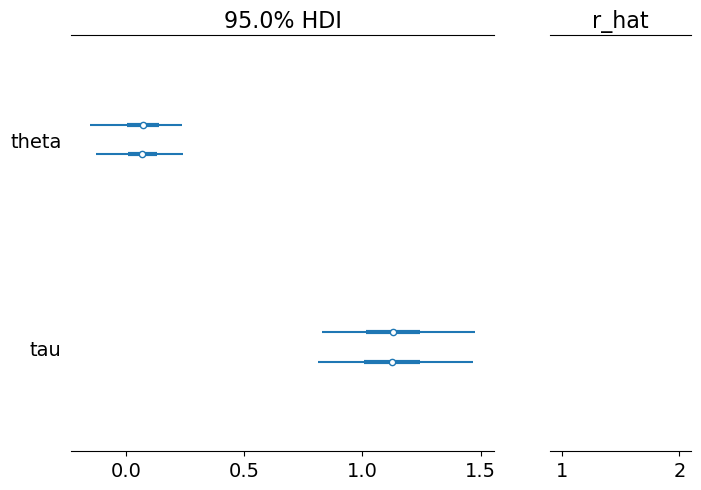

In [21]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True); #r_hat checks if the chains agree or not, appears if combined = True

## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [22]:
az.summary(idata, round_to=5)#2)

# hdi = credible intvl

# lower effective sample size for tau because of autocorrelation

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12831  0.16722  0.81633  1.44718    0.00577  0.00408   832.51104   
theta  0.06874  0.09646 -0.12744  0.23517    0.00218  0.00182  1993.96618   

         ess_tail    r_hat  
tau    1005.89782  0.99982  
theta  1264.46150  1.00187

In [23]:
theta.ravel().shape

(2000,)

### `mean` and `sd`

In [24]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(0.06874, 1.12831)

In [25]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

(0.09646, 0.16722)

### `hdi_3%` and `hdi_97%`

In [26]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12831  0.16722  0.81633  1.44718    0.00577  0.00408   832.51104   
theta  0.06874  0.09646 -0.12744  0.23517    0.00218  0.00182  1993.96618   

         ess_tail    r_hat  
tau    1005.89782  0.99982  
theta  1264.46150  1.00187

In [27]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([-0.09562,  0.21992])

In [28]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([-0.12909,  0.2512 ])

In [29]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([-0.12218,  0.24122])

In [30]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.139 ,  0.2315])

In [31]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.80167, 1.44066])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [32]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12831  0.16722  0.81633  1.44718    0.00577  0.00408   832.51104   
theta  0.06874  0.09646 -0.12744  0.23517    0.00218  0.00182  1993.96618   

         ess_tail    r_hat  
tau    1005.89782  0.99982  
theta  1264.46150  1.00187

In [33]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

0.002160172154965872

In [34]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

0.0057955308023604265

In [35]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


9.371120385807731e-08

In [36]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method 
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the 
#  standard deviation (SD) of a single variable 
#  without assuming normality using moments of moments 
#  and first order Taylor series approximation 
#  (Kenney and Keeping, 1951, p. 141)."

0.0031744484735506413

In [37]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.007855791382429096

In [38]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12831  0.16722  0.81633  1.44718    0.00577  0.00408   832.51104   
theta  0.06874  0.09646 -0.12744  0.23517    0.00218  0.00182  1993.96618   

         ess_tail    r_hat  
tau    1005.89782  0.99982  
theta  1264.46150  1.00187

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [39]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail


# turns into a binary of data, check if lower/higher than 0.05

0.05


array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False]])

1310.5061248393733

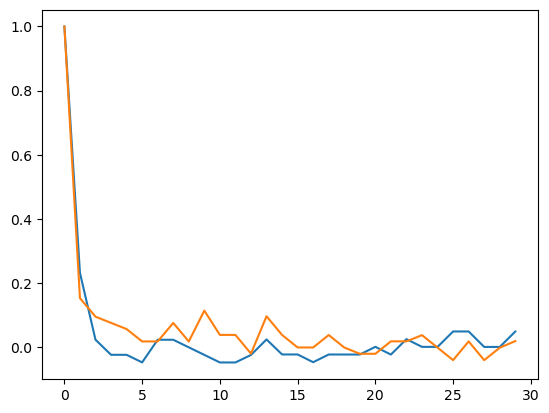

In [40]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k], 
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [41]:
autocorrelations[:,:10]

array([[ 1.00000000e+00,  2.32075472e-01,  2.38992748e-02,
        -2.31929503e-02, -2.32409443e-02, -4.68145156e-02,
         2.37159332e-02,  2.36698561e-02,  9.48742243e-05,
        -2.34824355e-02],
       [ 1.00000000e+00,  1.53389831e-01,  9.56136123e-02,
         7.63173133e-02,  5.70186455e-02,  1.84719536e-02,
         1.84141737e-02,  7.61000194e-02,  1.82982439e-02,
         1.14491064e-01]])

In [42]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

0.1


array([[False,  True, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False]])

1138.084906903593

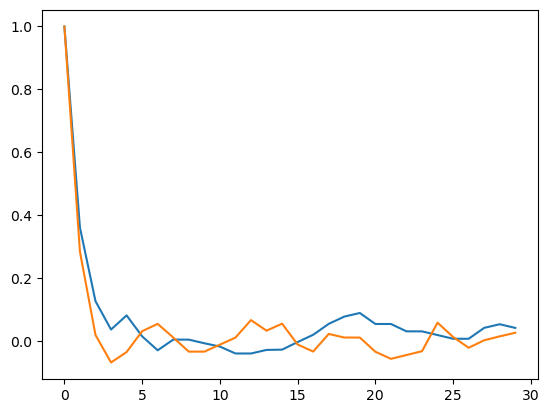

In [43]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k], 
                    tau_in_tail[c,t_plus_k:])[0,1]
        
for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [44]:
autocorrelations[:,:20]

array([[ 1.        ,  0.36090909,  0.12704347,  0.0368244 ,  0.08178493,
         0.01525493, -0.02915079,  0.00485625,  0.00474702, -0.00673821,
        -0.01717921, -0.03920306, -0.03931679, -0.02794371, -0.02704245,
        -0.00293225,  0.02015978,  0.05485863,  0.07796161,  0.08946491],
       [ 1.        ,  0.28405257,  0.01959226, -0.06783791, -0.03475686,
         0.0315364 ,  0.05493567,  0.01153071, -0.03326819, -0.03338443,
        -0.01115193,  0.01108536,  0.06685855,  0.03321778,  0.05546699,
        -0.01062764, -0.03320894,  0.02284626,  0.011499  ,  0.01138603]])

In [45]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12831  0.16722  0.81633  1.44718    0.00577  0.00408   832.51104   
theta  0.06874  0.09646 -0.12744  0.23517    0.00218  0.00182  1993.96618   

         ess_tail    r_hat  
tau    1005.89782  0.99982  
theta  1264.46150  1.00187

#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


2034.7876123478438

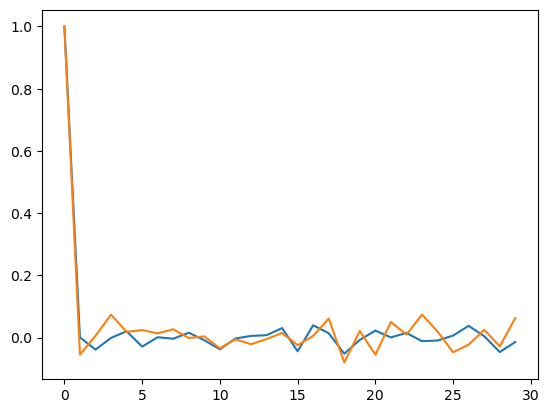

In [46]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k], 
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


# effective sample size of theta is bigger than tau because of less autocorrelation
# sample size is bigger than m because CORRELATION CAN BE NEGATIVE

# first-order autocorrelation is negative
     # i.e. if sample 1 is x higher than mean, sample 2 is x lower than mean


In [47]:
autocorrelations[:,:10]

array([[ 1.00000000e+00,  7.69856846e-04, -3.86466258e-02,
        -9.37943720e-04,  2.04005111e-02, -2.89407805e-02,
         1.16075908e-03, -3.66040954e-03,  1.56645361e-02,
        -8.46421913e-03],
       [ 1.00000000e+00, -5.47982006e-02,  5.83331779e-03,
         7.37201462e-02,  1.83547959e-02,  2.42709688e-02,
         1.35765188e-02,  2.67092679e-02, -1.33916283e-03,
         3.77609978e-03]])

923.0636940701967

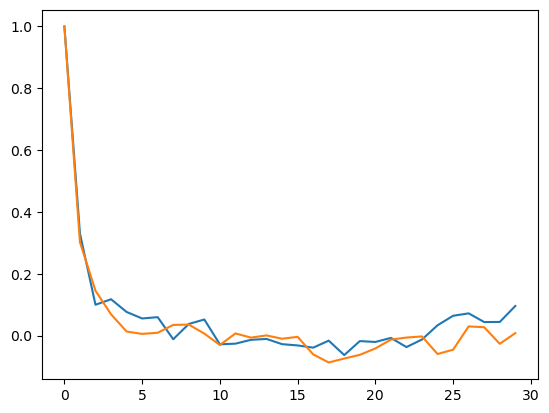

In [48]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [49]:
autocorrelations[:,:10]

array([[ 1.        ,  0.33058011,  0.0998666 ,  0.11772524,  0.07662707,
         0.05550402,  0.05974792, -0.01164106,  0.03772083,  0.05217519],
       [ 1.        ,  0.30235091,  0.14523598,  0.06900856,  0.01329473,
         0.00562013,  0.00933478,  0.03467107,  0.03569496,  0.00660343]])

In [50]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12831  0.16722  0.81633  1.44718    0.00577  0.00408   832.51104   
theta  0.06874  0.09646 -0.12744  0.23517    0.00218  0.00182  1993.96618   

         ess_tail    r_hat  
tau    1005.89782  0.99982  
theta  1264.46150  1.00187

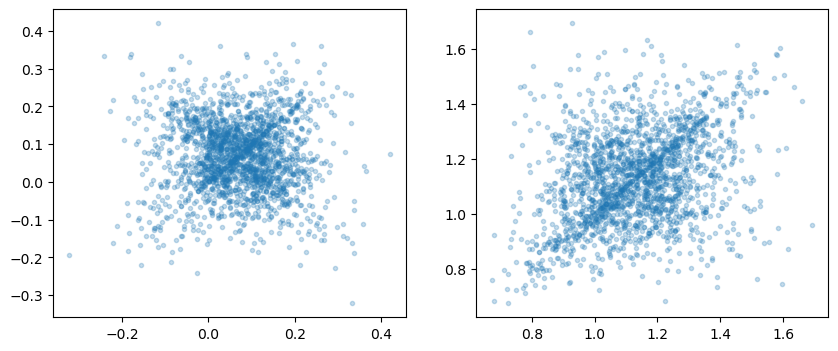

In [51]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

SHOULD BE CLOSE TO 1!!!!

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [52]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12831  0.16722  0.81633  1.44718    0.00577  0.00408   832.51104   
theta  0.06874  0.09646 -0.12744  0.23517    0.00218  0.00182  1993.96618   

         ess_tail    r_hat  
tau    1005.89782  0.99982  
theta  1264.46150  1.00187

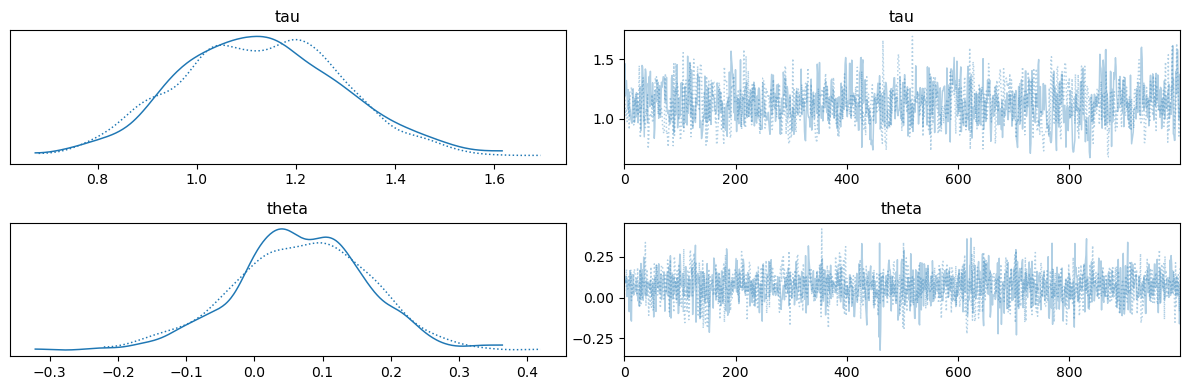

In [53]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


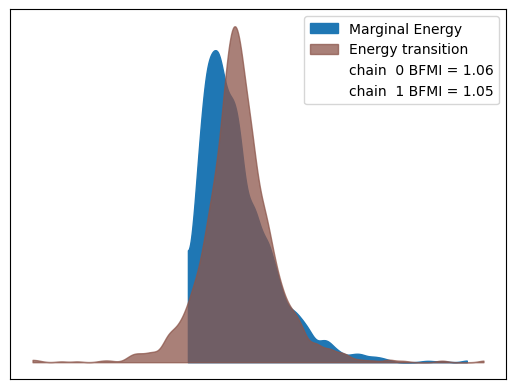

In [54]:
az.plot_energy(idata);

## Part D: Samplers


In [55]:
pymc.sample?

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.13  0.15    0.85     1.42        0.0      0.0   2576.03   2749.31   
theta  0.07  0.09   -0.12     0.24        0.0      0.0   1957.59   2260.33   

       r_hat  
tau      1.0  
theta    1.0

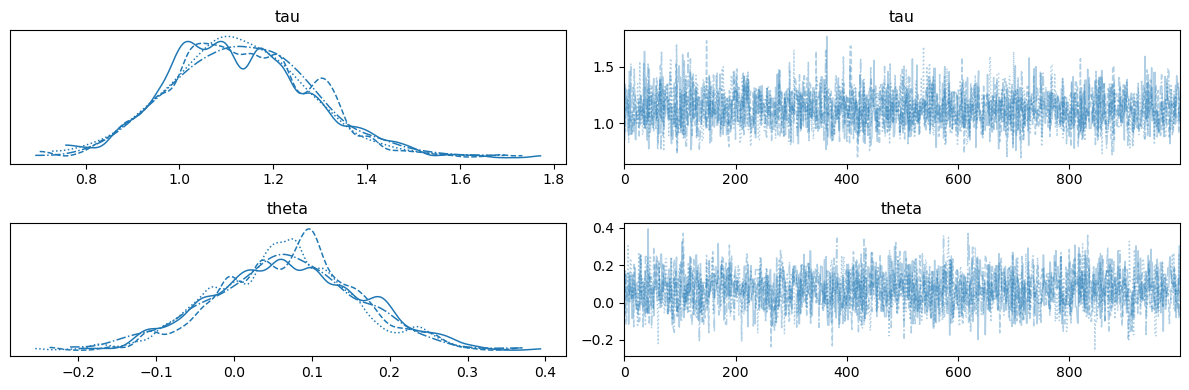

In [56]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)
    
display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()    

In [57]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.32132132, 0.36236236, 0.36536537, 0.28528529])

In [58]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.32132132, 0.36236236, 0.36536537, 0.28528529])

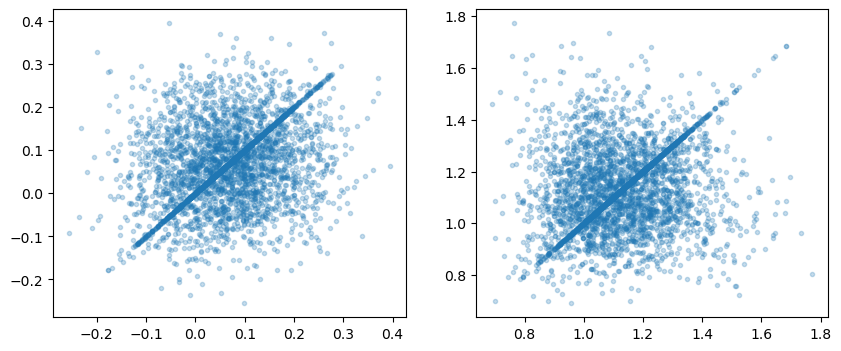

In [59]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1], 
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1], 
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

# the diagonal is all the rejections, high auto-correlation (failed to move)

# THIS IS CALLED HAMILTONIAN MONTE CARLO

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.13  0.16    0.83     1.42        0.0      0.0   3583.43   2736.11   
theta  0.07  0.09   -0.11     0.24        0.0      0.0   3854.58   2594.40   

       r_hat  
tau      1.0  
theta    1.0

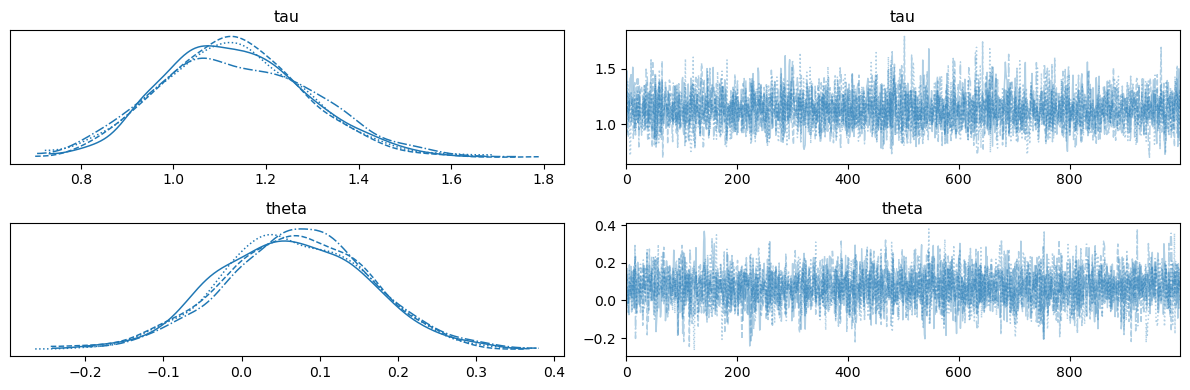

In [60]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)
    
display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()    

In [61]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

 # Target acceptance rate of 90% (as parameterized in cell above)

0         1         2         3         4         5         6    \
0  0.990230  0.962782  0.969046  1.000000  0.892728  0.797691  1.000000   
1  0.992895  0.873117  0.873648  0.971239  1.000000  0.999119  0.846668   
2  1.000000  0.997060  0.916843  0.480113  0.990028  0.981404  0.998873   
3  0.895897  0.749626  0.581617  0.971812  0.769304  0.966894  0.997902   

        7         8         9    ...       990       991       992       993  \
0  0.979493  1.000000  0.867429  ...  1.000000  0.986378  0.688317  0.747617   
1  0.515743  1.000000  1.000000  ...  0.924763  0.861515  0.997685  0.987599   
2  0.993120  0.819115  0.860871  ...  0.867583  0.534667  1.000000  0.968003   
3  0.995429  0.942851  0.988069  ...  0.930866  0.997200  0.996881  0.809196   

        994       995       996       997       998       999  
0  1.000000  0.917864  0.936089  1.000000  0.996325  0.946221  
1  0.960731  0.973027  1.000000  0.823060  0.903206  0.884544  
2  1.000000  0.975671  0.802142  0.968504  0.920675  0.483811  
3  0.833812  1.000000  0.986929  1.000000  1.000000  1.000000  

[4 rows x 1000 columns]

array([0.08258153, 0.08653038, 0.08704032, 0.09509736])

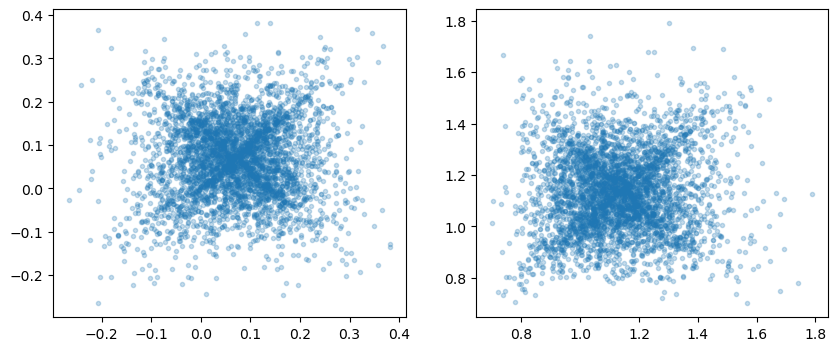

In [62]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1], 
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1], 
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

# benefit of this algorithm - reduces autocorrelation by a lot so higher chance of accepting a sample

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [theta]
>Slice: [tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.13  0.16    0.81     1.42        0.0      0.0   4031.64   2812.46   
theta  0.07  0.10   -0.11     0.25        0.0      0.0   3687.56   2775.69   

       r_hat  
tau      1.0  
theta    1.0

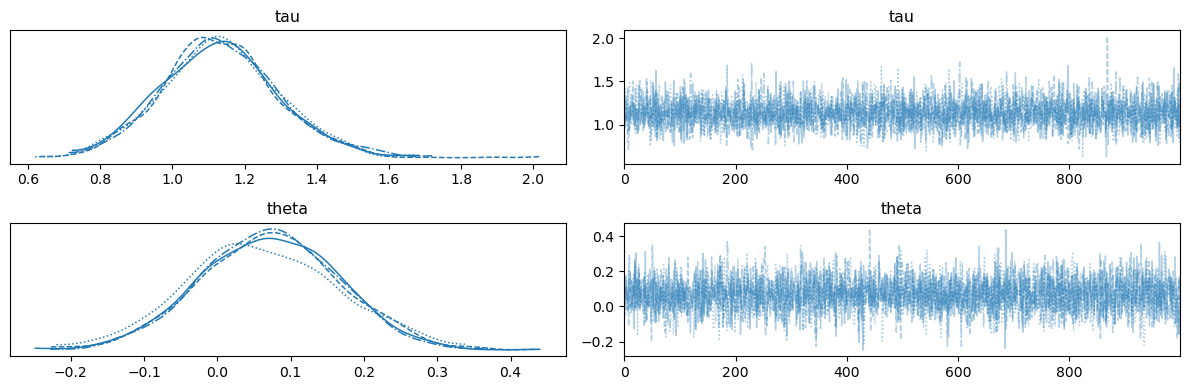

In [63]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()    

# slice sampler

# this is a gibbs sampler unlike ones before (bivariate samplers)
# doing slice step instead of metropolis step

In [64]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

# zero rejection rates, unlike MH

array([0., 0., 0., 0.])

In [65]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

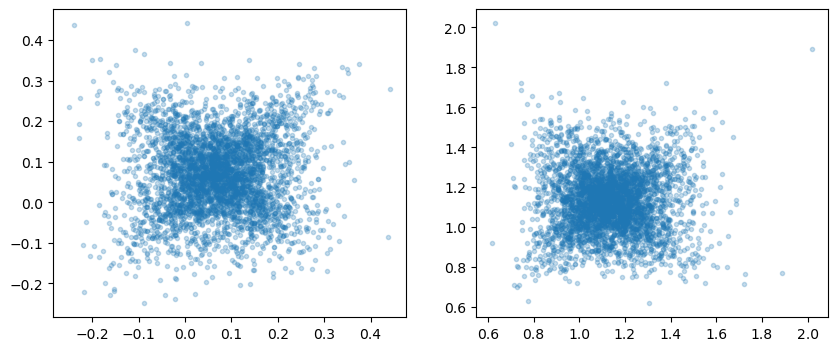

In [66]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.14  0.16    0.89     1.50       0.01     0.01    512.85    442.35   
theta  0.08  0.09   -0.08     0.26       0.00     0.00    297.06    275.58   

       r_hat  
tau     1.00  
theta   1.02

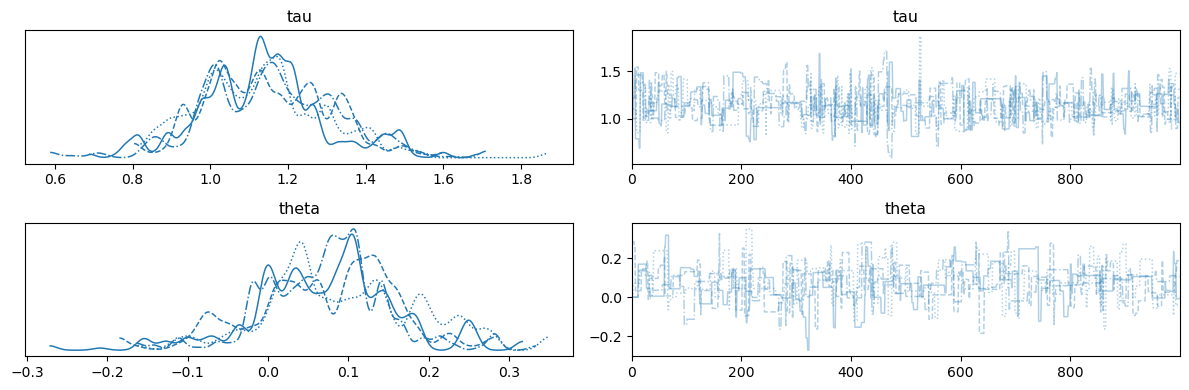

In [67]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()    

In [68]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.8968969 , 0.87987988, 0.87687688, 0.9049049 ])

In [69]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.82082082, 0.82782783, 0.82882883, 0.83283283])

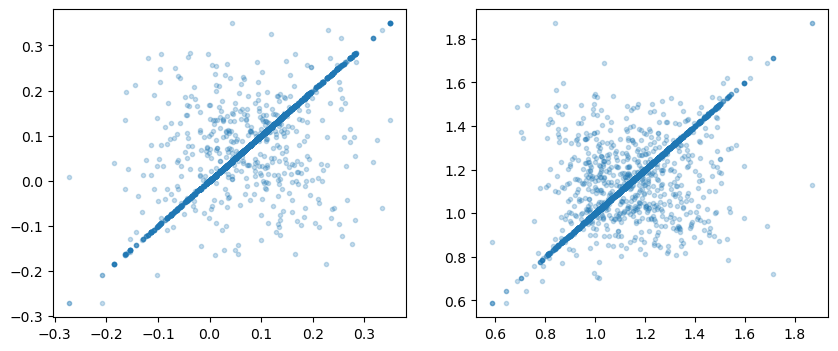

In [70]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

# very low effective sample size

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.14  0.16    0.86     1.43       0.01     0.01    293.26    549.97   
theta  0.07  0.09   -0.11     0.24       0.00     0.00    643.58    818.06   

       r_hat  
tau     1.02  
theta   1.00

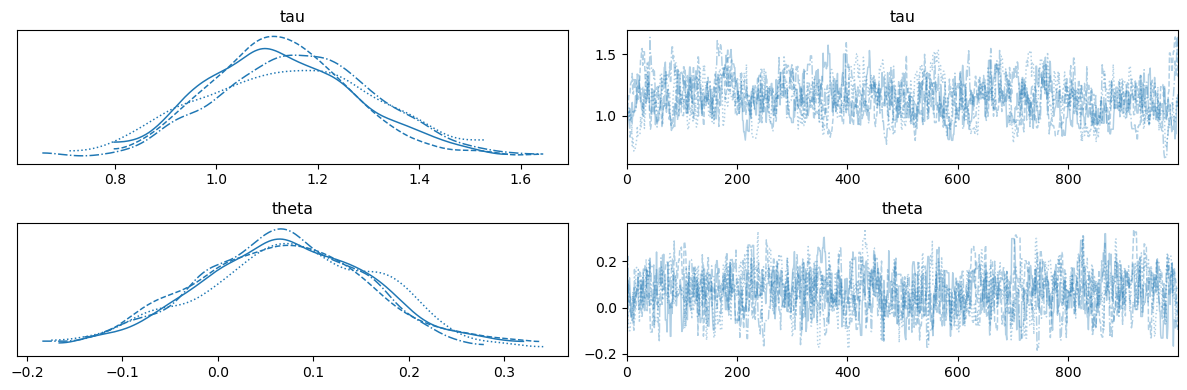

In [71]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()    

In [72]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

array([0.31131131, 0.30630631, 0.31631632, 0.31031031])

In [73]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

array([0.24524525, 0.23923924, 0.21221221, 0.21021021])

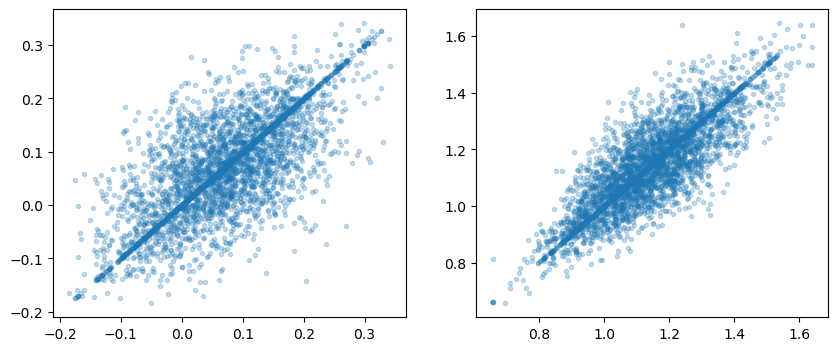

In [74]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

# less sticky chains than before, better sample size (but still garbage)

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- [Distribution Dimensionality](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/dimensionality.html#dimensionality)
- [PyMC and PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html#pymc-pytensor)
- [Using Data Containers](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)

| | | |
|-|-|-|
|1|2|3|


#### Etc.

- [Prior and posterior checks] (https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#posterior-predictive) (https://www.pymc.io/projects/docs/en/stable/_images/ff23516dbee6a363a9666322f96566d04330e625e30db70966f6d9dd677d6f8d.png)

- [Model Comparison] https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-comparison) (https://www.pymc.io/projects/docs/en/stable/_images/69bd250de55dfb612954797a0838bf15f33d8001365fbede3ae19d1656a495da.png)

- [Updating Priors] (https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html) (https://www.pymc.io/projects/examples/en/latest/_images/869b5446681e715a669de9b0305a3a1bbaf42c194354efa44542f781118022ae.png)


- [automatic marginalization discrete variables] (https://www.pymc.io/projects/examples/en/latest/howto/marginalizing-models.html) (https://www.pymc.io/projects/examples/en/latest/_images/36a3357f89d21ad98e89a8eef3179f83d6897f347714629d8ac8a85bd7100ad3.png)

- [how to debug model] (https://www.pymc.io/projects/examples/en/latest/howto/howto_debugging.html) (https://www.pymc.io/projects/examples/en/latest/_images/cd8d49dd3519e25c0ec2d3ef30a0816fe9c3f7708d9eda15d157590da6ca27b5.svg)

- [how to wrap function for use pymc] (https://www.pymc.io/projects/examples/en/latest/howto/wrapping_jax_function.html) (https://www.pymc.io/projects/examples/en/latest/_images/810705521c6d764cc52621beb88fb0f1160e1a92c804d6708c7c4f84aa34a535.png)


- [splines] (https://www.pymc.io/projects/examples/en/latest/howto/spline.html) (https://www.pymc.io/projects/examples/en/latest/_images/fc05f4904f9bc747ae16a7c7037f87b7dc39a480a2a24f0cff56f2ab9f1b9470.png)

- [bayesian copula estimation] (https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html) (https://www.pymc.io/projects/examples/en/latest/_images/copula_schematic.png)

-[Using ModelBuilder class for deploying PyMC models] (https://www.pymc.io/projects/examples/en/latest/howto/model_builder.html) (https://www.pymc.io/projects/examples/en/latest/_images/bbc4da85106ec9c236813f170272c9b249e0a8af0911c428cddbf54bb0752c74.png)

- [Using a “black box” likelihood function] (https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html) (https://www.pymc.io/projects/examples/en/latest/_images/64c6c9c70b40b4cf651b5ad2b2b1b84a1e7e93a5ed67fac4355a38fcecf47024.png)

- [LKJ Cholesky Covariance Priors for Multivariate Normal Models] (https://www.pymc.io/projects/examples/en/latest/howto/LKJ.html)\ (https://www.pymc.io/projects/examples/en/latest/_images/f859e4ca959a1c0fc8f886a6752ef8317cff5016e94dc17a7c1cc6ac2cd9535f.png)

- [bayesian missing data imputation] (https://www.pymc.io/projects/examples/en/latest/howto/Missing_Data_Imputation.html) (https://www.pymc.io/projects/examples/en/latest/_images/4651aee3b14cc8fcb4f416403736e3ecb5f7f8ce1171367a38f6c44a02888f86.png)






| | | | |
|-|-|-|-|
|1|2|3|4|
|5|6|7|8|
|9|10|11|12|


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*


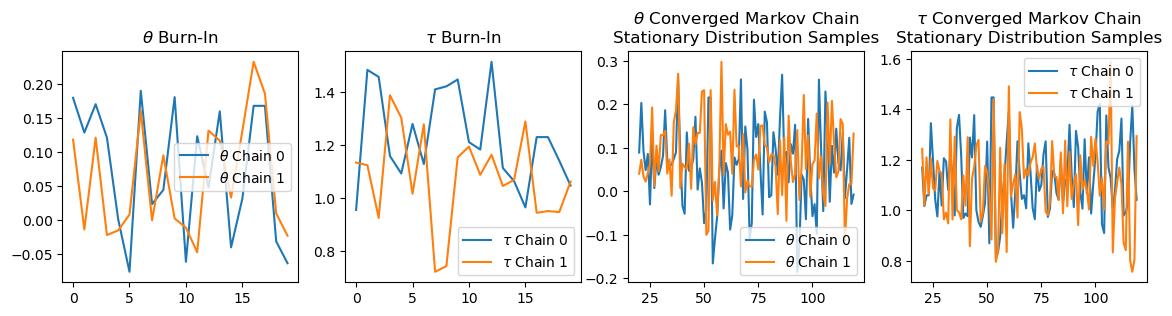

In [78]:
# 2.1

with conjugate_normal_gamma: # conjugate is when the posterior has the same distribution family as the prior

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data - prior "adds one data point"
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau  
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


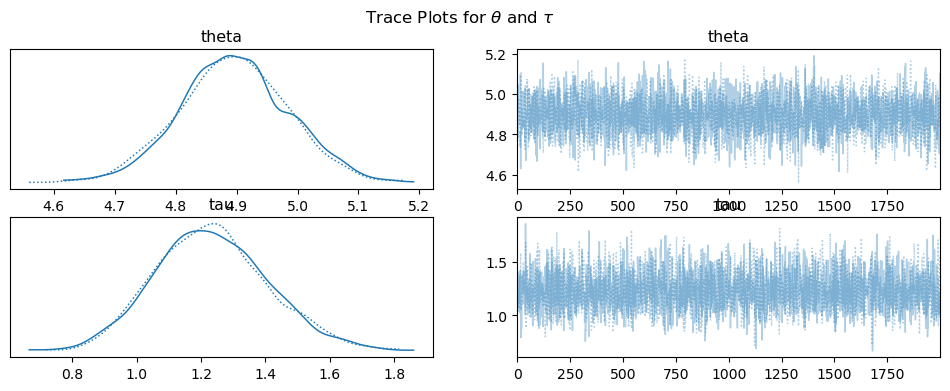

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  4.896  0.089   4.727    5.065      0.001    0.001    4478.0    2814.0   
tau    1.233  0.174   0.905    1.553      0.003    0.002    3639.0    2704.0   

       r_hat  
theta    1.0  
tau      1.0  


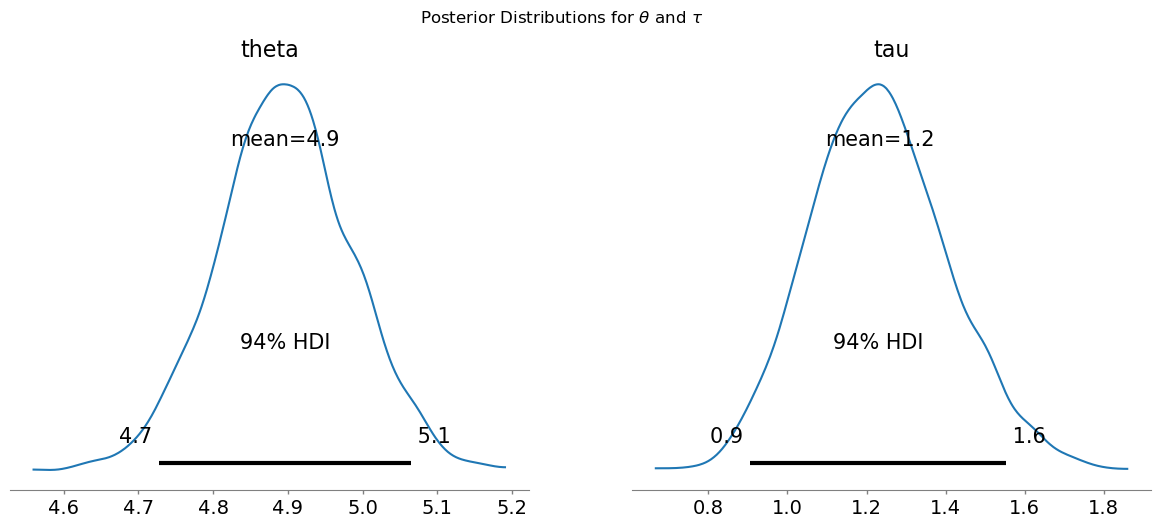

R-hat and ESS for theta: <xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    theta    float64 8B 1.001 <xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    theta    float64 8B 4.478e+03
R-hat and ESS for tau: <xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    tau      float64 8B 1.0 <xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    tau      float64 8B 3.639e+03


In [1]:
# 2.2
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
true_theta = 5  # True mean of the normal distribution
true_tau = 1    # True precision (1/variance) of the normal distribution
n_samples = 100  # Number of data points
x = np.random.normal(true_theta, np.sqrt(1 / true_tau), n_samples)

# Define the PyMC model
with pm.Model() as non_conjugate_model:
    # Priors for unknown model parameters
    # Non-normal prior for theta (e.g., Uniform distribution)
    theta = pm.Uniform("theta", lower=-10, upper=10)  # Uniform prior for theta
    
    # Non-gamma prior for tau (e.g., HalfNormal distribution)
    tau = pm.HalfNormal("tau", sigma=2)  # HalfNormal prior for tau
    
    # Likelihood (sampling distribution) of observations
    x_obs = pm.Normal("x_obs", mu=theta, tau=tau, observed=x)

    # Sample from the posterior
    idata = pm.sample(draws=2000, tune=1000, chains=2, return_inferencedata=True)

# Diagnostics and posterior analysis
# 1. Trace plots to assess convergence
az.plot_trace(idata, var_names=["theta", "tau"])
plt.suptitle("Trace Plots for $\\theta$ and $\\tau$")
plt.show()

# 2. Summary statistics
print(az.summary(idata, var_names=["theta", "tau"]))

# 3. Posterior distributions
az.plot_posterior(idata, var_names=["theta", "tau"])
plt.suptitle("Posterior Distributions for $\\theta$ and $\\tau$")
plt.show()

# 4. Effective sample size and R-hat statistics
print("R-hat and ESS for theta:", az.rhat(idata, var_names=["theta"]), az.ess(idata, var_names=["theta"]))
print("R-hat and ESS for tau:", az.rhat(idata, var_names=["tau"]), az.ess(idata, var_names=["tau"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


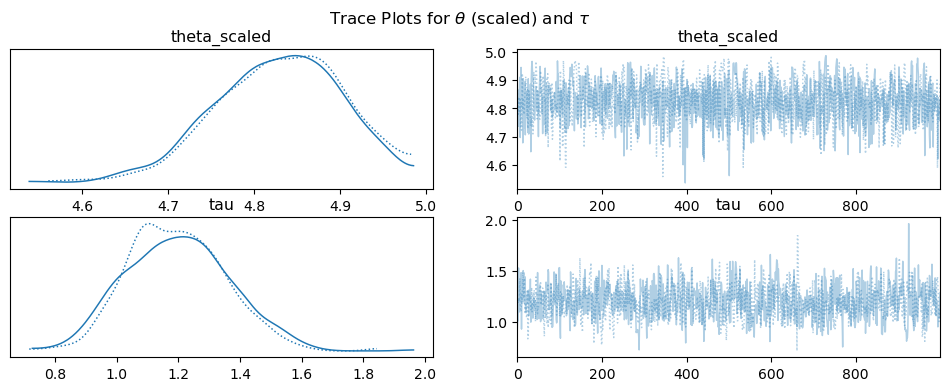

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_scaled  4.828  0.073   4.700    4.960      0.002    0.002    1084.0   
tau           1.197  0.161   0.907    1.491      0.005    0.004     900.0   

              ess_tail  r_hat  
theta_scaled     924.0    1.0  
tau              818.0    1.0  


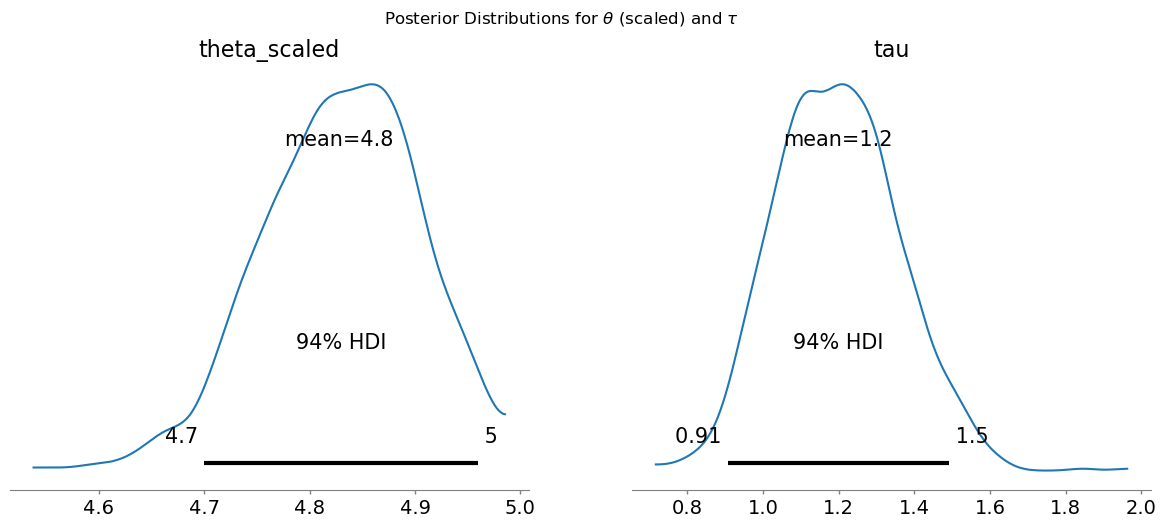

R-hat and ESS for theta_scaled: <xarray.Dataset> Size: 8B
Dimensions:       ()
Data variables:
    theta_scaled  float64 8B 1.002 <xarray.Dataset> Size: 8B
Dimensions:       ()
Data variables:
    theta_scaled  float64 8B 1.084e+03
R-hat and ESS for tau: <xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    tau      float64 8B 1.003 <xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    tau      float64 8B 900.5


In [4]:
# 2.3

import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
true_theta = 5  # True mean of the normal distribution
true_tau = 1    # True precision (1/variance) of the normal distribution
n_samples = 100  # Number of data points
x = np.random.normal(true_theta, np.sqrt(1 / true_tau), n_samples)

# Define the PyMC model
with pm.Model() as custom_prior_model:
    # Priors for unknown model parameters
    # Non-normal prior for theta (e.g., Beta distribution scaled to a range)
    theta = pm.Beta("theta", alpha=2, beta=2)  # Beta prior for theta
    theta_scaled = pm.Deterministic("theta_scaled", 10 * theta - 5)  # Scale to [-5, 5]
    
    # Non-gamma prior for tau (e.g., Exponential distribution)
    tau = pm.Exponential("tau", lam=1)  # Exponential prior for tau
    
    # Likelihood (sampling distribution) of observations
    x_obs = pm.Normal("x_obs", mu=theta_scaled, tau=tau, observed=x)

    # Sample from the posterior
    idata = pm.sample(draws=1000, tune=500, chains=2, return_inferencedata=True, target_accept=0.9)

# Diagnostics and posterior analysis
# 1. Trace plots to assess convergence
az.plot_trace(idata, var_names=["theta_scaled", "tau"])
plt.suptitle("Trace Plots for $\\theta$ (scaled) and $\\tau$")
plt.show()

# 2. Summary statistics
print(az.summary(idata, var_names=["theta_scaled", "tau"]))

# 3. Posterior distributions
az.plot_posterior(idata, var_names=["theta_scaled", "tau"])
plt.suptitle("Posterior Distributions for $\\theta$ (scaled) and $\\tau$")
plt.show()

# 4. Effective sample size and R-hat statistics
print("R-hat and ESS for theta_scaled:", az.rhat(idata, var_names=["theta_scaled"]), az.ess(idata, var_names=["theta_scaled"]))
print("R-hat and ESS for tau:", az.rhat(idata, var_names=["tau"]), az.ess(idata, var_names=["tau"]))

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [76]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


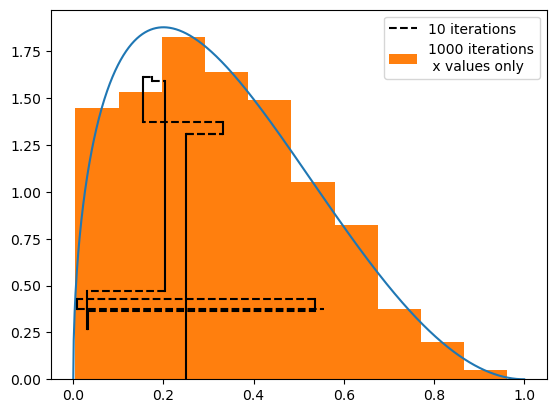

In [77]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

### Explanation of Slice Sampling and Its Use in Metropolis-within-Gibbs

#### **1. How Slice Sampling Works**

Slice sampling is a Markov Chain Monte Carlo (MCMC) algorithm used to sample from a probability distribution. The key idea is to sample uniformly from the region under the curve of the target probability density function (PDF). Here's how it works:

1. **Target Distribution**:
   - Let $f(x)$ be the target PDF (up to a normalizing constant) from which we want to sample.

2. **Slice Level**:
   - At each step, given the current state $x$, we draw a horizontal slice level $y$ uniformly from the interval $[0, f(x)]$. This defines a "slice" $S = \{x' : f(x') \geq y\}$.

3. **Interval Selection**:
   - We identify an interval $[a, b]$ that contains the slice $S$. This interval is chosen such that $f(a) < y$ and $f(b) < y$.

4. **Uniform Sampling**:
   - We sample a new point $x'$ uniformly from the interval $[a, b]$. If $f(x') \geq y$, we accept $x'$ as the new state. Otherwise, we shrink the interval and repeat the process.

5. **Repeat**:
   - The process is repeated to generate a sequence of samples from the target distribution.

#### **2. Slice Sampling in Metropolis-within-Gibbs**

In a **Metropolis-within-Gibbs** algorithm, we update each parameter of the model one at a time, using a Metropolis-Hastings (MH) step for each parameter. However, if the full conditionals are only known up to a normalizing constant, slice sampling can be used as an alternative to MH for sampling from these conditionals.

Here’s how slice sampling can be used in place of an MH step:

1. **Full Conditionals**:
   - Suppose we have a model with parameters $\theta_1, \theta_2, \dots, \theta_k$. In Gibbs sampling, we sample each parameter $\theta_i$ from its full conditional distribution $p(\theta_i | \theta_{-i}, \text{data})$, where $\theta_{-i}$ represents all other parameters.

2. **Slice Sampling for Full Conditionals**:
   - For each parameter $\theta_i$, we treat its full conditional $p(\theta_i | \theta_{-i}, \text{data})$ as the target distribution $f(\theta_i)$.
   - We use slice sampling to draw a new value of $\theta_i$ from this target distribution.

3. **Steps**:
   - **Initialization**: Start with an initial value $\theta_i^{(0)}$.
   - **Slice Level**: Draw a slice level $y$ uniformly from $[0, f(\theta_i^{(t)})]$.
   - **Interval Selection**: Find an interval $[a, b]$ that contains the slice $S = \{\theta_i : f(\theta_i) \geq y\}$.
   - **Uniform Sampling**: Sample $\theta_i^{(t+1)}$ uniformly from $[a, b]$. If $f(\theta_i^{(t+1)}) \geq y$, accept it; otherwise, shrink the interval and repeat.

4. **Repeat for All Parameters**:
   - Repeat the above steps for each parameter $\theta_i$ in turn, updating one parameter at a time while keeping the others fixed.

#### **3. The Curve We're Sampling Beneath**

- The curve we're sampling beneath is the target PDF $f(x)$, which represents the full conditional distribution of the parameter being updated.
- The slice level $y$ defines a horizontal line, and the region under the curve where $f(x) \geq y$ is the slice $S$.
- We sample uniformly from this slice to generate new values of the parameter.

#### **4. Initial Value and Steps for Gibbs Sampling**

1. **Initial Value**:
   - Start with an initial value $x_0$ for the parameter being sampled.

2. **Steps**:
   - **Draw Slice Level**: Given the current value $x_t$, draw a slice level $y$ uniformly from $[0, f(x_t)]$.
   - **Find Interval**: Identify an interval $[a, b]$ that contains the slice $S = \{x : f(x) \geq y\}$.
   - **Sample New Value**: Sample $x_{t+1}$ uniformly from $[a, b]$. If $f(x_{t+1}) \geq y$, accept it; otherwise, shrink the interval and repeat.

3. **Repeat for All Parameters**:
   - Repeat the above steps for each parameter in the model, updating one parameter at a time.

#### **5. Visualization in the Provided Code**

The provided code demonstrates slice sampling for a Beta distribution $f(x) = \text{Beta}(1.5, 3)$. The key steps are:

1. **Initialization**:
   - Start with an initial value $x_0 = 0.25$.

2. **Slice Sampling**:
   - For each iteration, draw a slice level $y$ uniformly from $[0, f(x_t)]$.
   - Use the `slice_f_at_y` function to find a new value $x_{t+1}$ that lies under the curve $f(x)$.

3. **Trace Plot**:
   - The trace plot shows the progression of the sampled values over iterations, with the first 10 iterations highlighted.

4. **Histogram**:
   - The histogram of the sampled values approximates the target Beta distribution.
